In [1]:
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

import urbanFormPy as up

In [2]:
# initialise path, names, etc.
city_name = 'Paris'
epsg = 27571
crs = {'init': 'epsg:' + str(epsg)}

### Download the network

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
# download graph and clean (see network notebook for details on the cleaning process)

place = 'Paris, Ile-de-France'
download_method = 'OSMpolygon'
distance = None
nodes_graph, edges_graph = up.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph, edges_graph = up.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            self_loops = True, same_uv_edges = True)

### Load from local path

In [3]:
loading_path = 'Outputs/'+city_name+'/'
nodes_graph = gpd.read_file(loading_path+city_name+'_nodes_simplified.shp')
edges_graph = gpd.read_file(loading_path+city_name+'_edges_simplified.shp')

try:
    nodes_graph, edges_graph = nodes_graph.to_crs(epsg=epsg), edges_graph.to_crs(epsg=epsg)
except:
    nodes_graph.crs, edges_graph.crs = crs, crs

nodes_graph.index, edges_graph.index  = nodes_graph.nodeID, edges_graph.edgeID
nodes_graph.index.name, edges_graph.index.name  = None, None

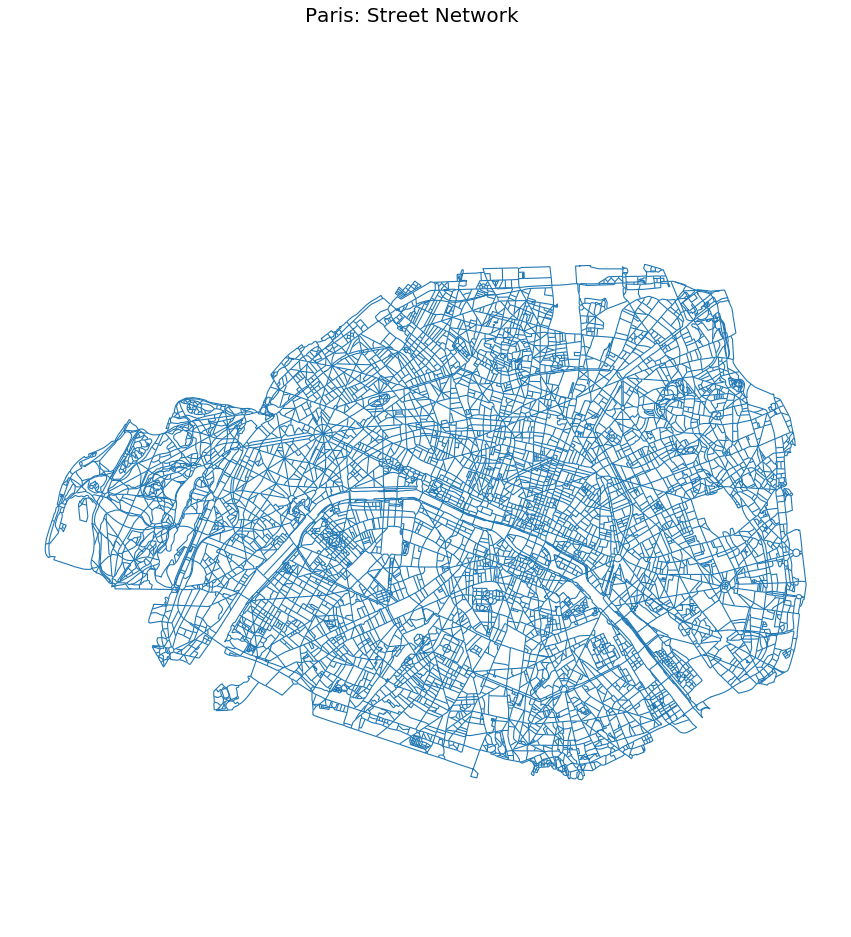

In [6]:
up.plot_lines(edges_graph, scheme = None, black_background = False, fig_size = 15, title = city_name+': Street Network')

## Barriers identification

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)
* *polygon*, provide a Polygon (coordinates must be in units of latitude-longitude degrees).

In [4]:
# define method and create envelope with wgs coordinate system
download_method = 'polygon'
place = up.envelope_wgs(edges_graph)
distance = None

In [5]:
road_barriers = up.road_barriers(place, download_method, distance, epsg, include_primary = True)
water_barriers = up.water_barriers(place, download_method, distance, epsg)
railway_barriers = up.railway_barriers(place, download_method, distance, epsg)
park_barriers = up.park_barriers(place, download_method, distance, epsg, min_area = 100000)

In [6]:
barriers = road_barriers.append(water_barriers)
barriers = railway_barriers.append(barriers)
barriers = park_barriers.append(barriers)
barriers.reset_index(inplace = True, drop = True)
barriers['barrierID'] = barriers.index.astype(int)

envelope = edges_graph.unary_union.envelope
barriers_within = barriers[barriers.intersects(edges_graph.unary_union.envelope)]

### Visualisation

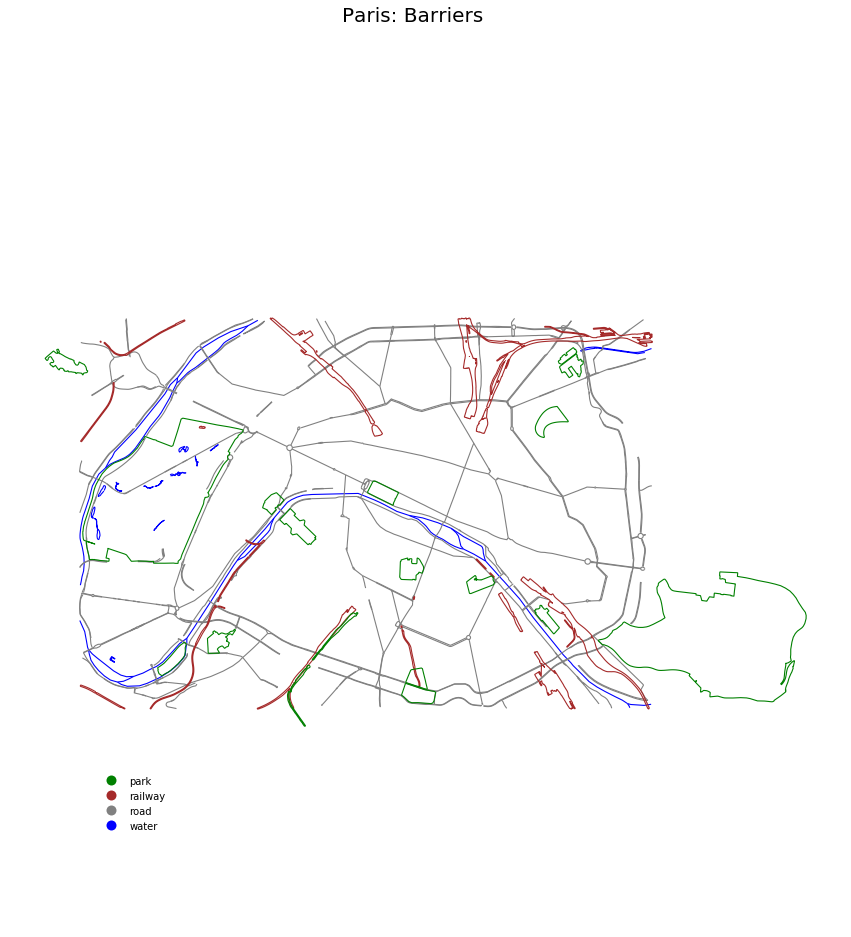

In [7]:
up.plot_barriers(barriers_within, black_background = False, fig_size = 15, title = city_name+': Barriers', legend = True)

In [11]:
# save barriers_gdf
saving_path = 'Outputs/'+city_name+'/'
barriers.to_file(saving_path+city_name+"_barriers.shp", driver='ESRI Shapefile')

### Assigning barriers to street segments

### Type of barriers

Choose between the following methods:
* *Positive barriers* - pedestrian perspective: Waterbodies, Parks.
* *Negative barriers* - pedestrian perspective: Major Roads, Railway Structures.
* *Structuring barriers* - barriers which structure and shape the image of the city: Waterbodies, Major roads, Railways.

In [12]:
sindex = edges_graph.sindex

# along and within POSITIVE BARRIERS
# rivers
edges_graph = up.along_water(edges_graph, barriers_within)
# parks
edges_graph = up.along_within_parks(edges_graph, barriers_within)
# altogheter
edges_graph['p_barr'] = edges_graph['a_rivers']+edges_graph['aw_parks']
edges_graph['p_barr'] = edges_graph.apply(lambda row: list(set(row['p_barr'])), axis = 1)

# along NEGATIVE BARRIERS                                    
tmp = barriers_within[barriers_within['type'].isin(['railway', 'road'])]
edges_graph['n_barr'] = edges_graph.apply(lambda row: up.barriers_along(row['edgeID'], edges_graph, tmp, sindex,
                                            offset = 25), axis = 1)

# crossing any kind of barrier but parks - STRUCTURING BARRIERS
edges_graph = up.assign_structuring_barriers(edges_graph, barriers_within)

## Visualisation

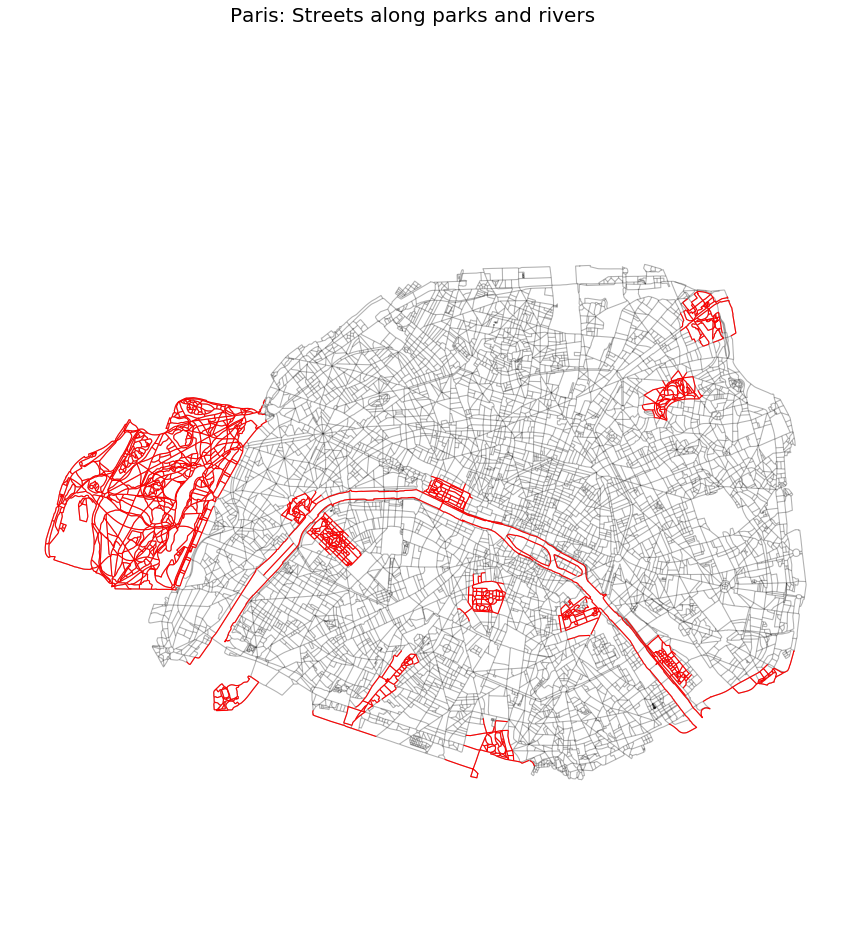

In [13]:
# positive barriers
edges_graph['p_bool'] = edges_graph.apply(lambda row: True if len(row['p_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.p_bool == True].copy()
up.plot_lines(tmp, black_background = False, fig_size = 15, color = 'red', title = city_name+': Streets along parks and rivers', 
              legend = False, gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black')

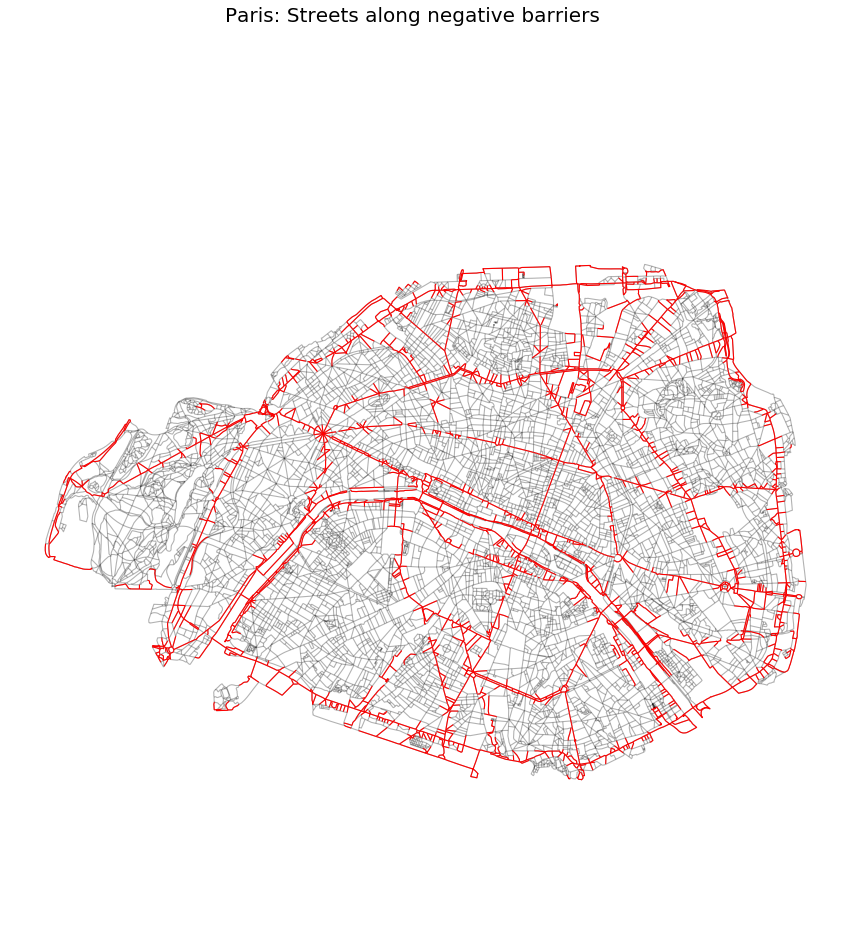

In [15]:
# negative barriers
edges_graph['n_bool'] = edges_graph.apply(lambda row: True if len(row['n_barr']) > 0 else False, axis = 1)
tmp = edges_graph[edges_graph.n_bool == True].copy()
up.plot_lines(tmp, black_background = False, fig_size = 15, color = 'red', title = city_name+': Streets along negative barriers',
              legend = False, gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black')

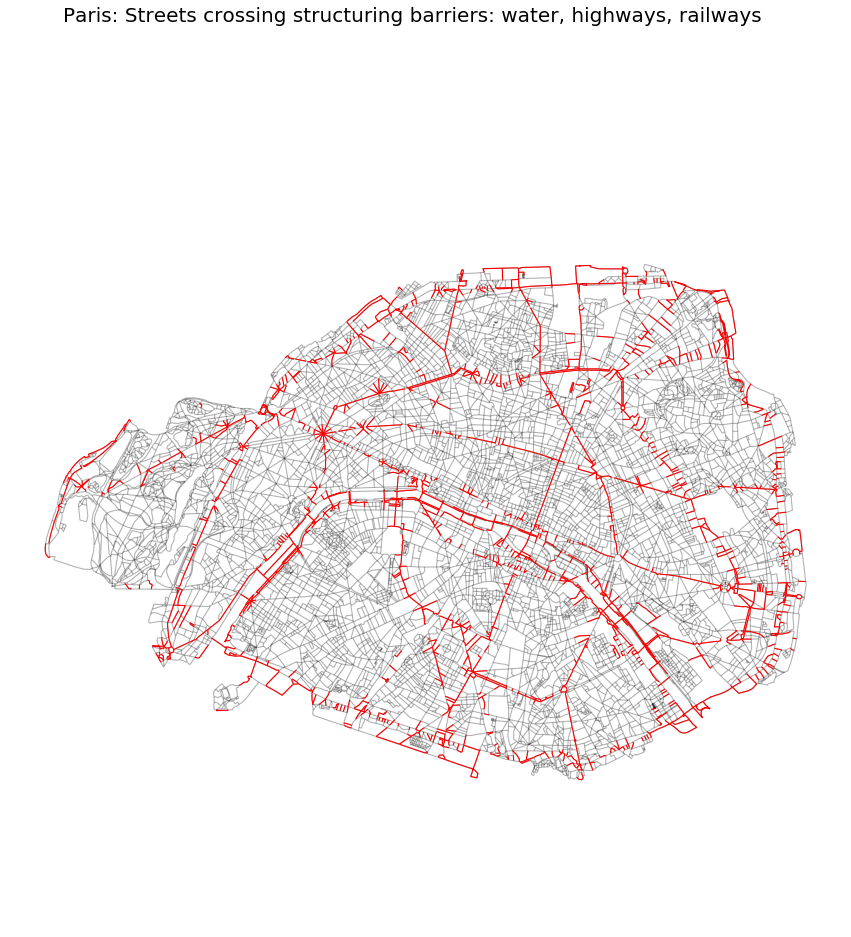

In [14]:
# separating barriers
tmp = edges_graph[edges_graph.sep_barr == True].copy()
up.plot_lines(tmp, black_background = False, fig_size = 15,  color = 'red', 
              title = city_name+': Streets crossing structuring barriers: water, highways, railways',
              gdf_base_map = edges_graph, base_map_alpha = 0.3, base_map_color = 'black', legend = False)

### Save 

In [6]:
# convertin list fields to string
to_convert = ['a_rivers', 'aw_parks','n_barr', 'p_barr']
edges_graph_string = edges_graph.copy()
for column in to_convert: edges_graph_string[column] = edges_graph_string[column].astype(str)

saving_path = 'Outputs/'+city_name+'/'
edges_graph_string.to_file(saving_path+city_name+"_edges_simplified.shp", driver='ESRI Shapefile')
nodes_graph.to_file(saving_path+city_name+'_nodes_simplified.shp', driver='ESRI Shapefile')